In [147]:
import matplotlib.pyplot as plt
import numpy as np

features = np.load('../ABIDEII/data/features.npz')['x']
labels = np.load("../ABIDEII/data/labels.npy")
sex = np.load("../ABIDEII/data/sex.npy")
features_transformed = np.load('../ABIDEII/data/features_transformed.npz')['x']

In [148]:
# check dimensions
print("Correlation matrix features:", features.shape)
print("Connectivity matrix features:", features_transformed.shape)
print("Category labels:",len(labels))
print("Sex labels:",len(sex))

Correlation matrix features: (403, 903)
Connectivity matrix features: (403, 903)
Category labels: 403
Sex labels: 403


In [149]:
# baseline dummy
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

dummy_classifier_mf = DummyClassifier(strategy="most_frequent")
dummy_classifier_mf.fit(X_train, y_train)

y_hat = dummy_classifier_mf.predict(X_test)
acc_mf = accuracy_score(y_test, y_hat)
print(f"Dummy Accuracy score (most frequent) : {acc_mf}")

dummy_classifier_strat = DummyClassifier(strategy="stratified")
dummy_classifier_strat.fit(X_train, y_train)

y_hat = dummy_classifier_strat.predict(X_test)
acc_strat = accuracy_score(y_test, y_hat)
print(f"Dummy Accuracy score (stratified) : {acc_strat}")

Dummy Accuracy score (most frequent) : 0.4752475247524752
Dummy Accuracy score (stratified) : 0.5544554455445545


## Setting aside some samples for testing with only males/only females at the end

In [150]:
from sklearn.model_selection import train_test_split

# shuffling before selection because the features are ordered by subject ID => grouped by site
# random_state=int to have repeatable results
# stratify=True to keep balance of the 2 classes

# correlation matrix features
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(features, labels, sex, test_size=0.15, shuffle=True, random_state=1, stratify=labels)

# connectivity matrix features (Fisher's z-transformed correlation matrix)
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, sex_train_transformed, sex_test_transformed = train_test_split(features_transformed, labels, sex, test_size=0.15, shuffle=True, random_state=1, stratify=labels)

# Training

## Search of the best model using nested k-fold cross validation with grid search
Using Repeated Stratified k-fold in inner cv

  ## Logistic Regression

In [151]:
from numpy import mean
from numpy import std
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

outer_results_lr = []
outer_results_train_lr = []
best_models_lr_corrmatrix = []
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    X_train_nested, X_test_nested = X_train[train_ix, :], X_train[test_ix, :]
    y_train_nested, y_test_nested = y_train[train_ix], y_train[test_ix]
    # configure the cross-validation procedure
    cv_inner = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    model_lr =LogisticRegression(solver="liblinear", penalty="l1")
    # define search space
    # p_grid = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}  # first try: best param was either 0.1 or 0.5 -> try to fine-tune around this range
    p_grid = {"C": [0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
    # define search
    clf_lr = GridSearchCV(estimator=model_lr, param_grid=p_grid, cv=cv_inner, scoring='accuracy', n_jobs=1, return_train_score=True, refit=True)
    # execute search
    result_lr = clf_lr.fit(X_train_nested, y_train_nested)
    # get the best performing model fit on the whole training set
    best_model_lr = result_lr.best_estimator_
    yhat_lr = best_model_lr.predict(X_test_nested)
    # evaluate the model
    acc_lr = accuracy_score(y_test_nested, yhat_lr)
    acc_train_lr = clf_lr.cv_results_['mean_train_score']
    # store the result
    best_models_lr_corrmatrix.append(best_model_lr)
    outer_results_lr.append(acc_lr)
    outer_results_train_lr.append(acc_train_lr)
    # report progress
    print('>Accuracy=%.3f (train: %.3f), Best score=%.3f, Best param=%s' % (acc_lr, mean(acc_train_lr), result_lr.best_score_, result_lr.best_params_))
# summarize the estimated performance of the model
print('LR: Accuracy: mean %.3f (std %.3f)' % (mean(outer_results_lr), std(outer_results_lr)))

>Accuracy=0.551 (train: 0.805), Best score=0.538, Best param={'C': 0.2}
>Accuracy=0.565 (train: 0.805), Best score=0.547, Best param={'C': 0.2}
>Accuracy=0.559 (train: 0.820), Best score=0.573, Best param={'C': 0.09}
>Accuracy=0.500 (train: 0.795), Best score=0.545, Best param={'C': 0.2}
>Accuracy=0.588 (train: 0.816), Best score=0.608, Best param={'C': 0.1}
LR: Accuracy: mean 0.553 (std 0.029)


In [153]:
clf_lr.cv_results_

{'mean_fit_time': array([0.00438705, 0.00459625, 0.00598361, 0.00662672, 0.00737833,
        0.00794698, 0.00855151]),
 'std_fit_time': array([0.00077147, 0.00056906, 0.00039296, 0.00028718, 0.00040374,
        0.00036732, 0.00052848]),
 'mean_score_time': array([0.00037796, 0.00035795, 0.00034422, 0.00033742, 0.00035975,
        0.00035651, 0.00036337]),
 'std_score_time': array([9.00270580e-05, 4.37719788e-05, 4.43796460e-05, 2.87928143e-05,
        6.00327347e-05, 4.46770017e-05, 5.87536961e-05]),
 'param_C': masked_array(data=[0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.09},
  {'C': 0.1},
  {'C': 0.2},
  {'C': 0.3},
  {'C': 0.4},
  {'C': 0.5},
  {'C': 0.6}],
 'split0_test_score': array([0.6       , 0.6       , 0.56363636, 0.6       , 0.54545455,
        0.54545455, 0.58181818]),
 'split1_test_score': array([0.6       , 0.65454545, 0.49090909, 0.5454

## SVM

In [154]:
from sklearn.svm import SVC

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

outer_results_svm = []
outer_results_train_svm = []
best_models_svm_corrmatrix = []
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    X_train_nested, X_test_nested = X_train[train_ix, :], X_train[test_ix, :]
    y_train_nested, y_test_nested = y_train[train_ix], y_train[test_ix]
    # configure the cross-validation procedure
    cv_inner = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    model_svm = SVC(kernel="linear")
    # define search space
    # p_grid = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}  # first try: best param was 0.01 -> try to fine-tune around this range
    p_grid = {"C": [0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013]}    # define search
    clf_svm = GridSearchCV(estimator=model_svm, param_grid=p_grid, cv=cv_inner, return_train_score=True,  n_jobs=1, refit=True)
    # execute search
    result_svm = clf_svm.fit(X_train_nested, y_train_nested)
    # get the best performing model fit on the whole training set
    best_model_svm = result_svm.best_estimator_
    yhat_svm = best_model_svm.predict(X_test_nested)
    # evaluate the model
    acc_svm = accuracy_score(y_test_nested, yhat_svm)
    acc_train_svm = clf_svm.cv_results_['mean_train_score']
    # store the result
    best_models_svm_corrmatrix.append(best_model_svm)
    outer_results_svm.append(acc_svm)
    outer_results_train_svm.append(acc_train_svm)
    # report progress
    print('>Accuracy=%.3f (train: %.3f), Best score=%.3f, Best param=%s' % (acc_svm, mean(acc_train_svm), result_svm.best_score_, result_svm.best_params_))
# summarize the estimated performance of the model
print('SVM: Accuracy: mean %.3f (std %.3f)' % (mean(outer_results_svm), std(outer_results_svm)))

>Accuracy=0.551 (train: 0.909), Best score=0.563, Best param={'C': 0.008}
>Accuracy=0.580 (train: 0.911), Best score=0.560, Best param={'C': 0.009}
>Accuracy=0.559 (train: 0.926), Best score=0.568, Best param={'C': 0.013}
>Accuracy=0.603 (train: 0.916), Best score=0.538, Best param={'C': 0.008}
>Accuracy=0.574 (train: 0.928), Best score=0.565, Best param={'C': 0.013}
SVM: Accuracy: mean 0.573 (std 0.018)


# Testing

Divide the testing set in male and female sets

In [155]:
X_females_test = []
y_females_test = []
X_males_test = []
y_males_test = []
for i in range(len(X_test)):
    if sex_test[i] == 1:
        X_males_test.append(X_test[i])
        y_males_test.append(y_test[i])
    else:
        X_females_test.append(X_test[i])
        y_females_test.append(y_test[i])

X_females_test_transformed = []
y_females_test_transformed = []
X_males_test_transformed = []
y_males_test_transformed = []
for i in range(len(X_test_transformed)):
    if sex_test_transformed[i] == 1:
        X_males_test_transformed.append(X_test_transformed[i])
        y_males_test_transformed.append(y_test_transformed[i])
    else:
        X_females_test_transformed.append(X_test_transformed[i])
        y_females_test_transformed.append(y_test_transformed[i])

In [156]:
print("Female test set size: ",len(X_females_test))
print("Male test set size: ", len(X_males_test))

Female test set size:  27
Male test set size:  34


In [157]:
scores_f_lr = []
for model in best_models_lr_corrmatrix:
    pred_f = model.predict(X_females_test)
    acc_f = accuracy_score(y_females_test, pred_f)
    scores_f_lr.append(acc_f)
scores_f_lr

[0.4444444444444444,
 0.48148148148148145,
 0.7037037037037037,
 0.4074074074074074,
 0.6666666666666666]

In [158]:
scores_m_lr = []
for model in best_models_lr_corrmatrix:
    pred_m = model.predict(X_males_test)
    acc_m = accuracy_score(y_males_test, pred_m)
    scores_m_lr.append(acc_m)
scores_m_lr

[0.6764705882352942,
 0.5588235294117647,
 0.38235294117647056,
 0.6176470588235294,
 0.5294117647058824]

In [159]:
scores_f_svm = []
for model in best_models_svm_corrmatrix:
    pred_f = model.predict(X_females_test)
    acc_f = accuracy_score(y_females_test, pred_f)
    scores_f_svm.append(acc_f)
scores_f_svm

[0.4074074074074074,
 0.5555555555555556,
 0.5185185185185185,
 0.48148148148148145,
 0.5185185185185185]

In [160]:
scores_m_svm = []
for model in best_models_svm_corrmatrix:
    pred_m = model.predict(X_males_test)
    acc_m = accuracy_score(y_males_test, pred_m)
    scores_m_svm.append(acc_m)
scores_m_svm

[0.6176470588235294,
 0.5294117647058824,
 0.6470588235294118,
 0.6470588235294118,
 0.5588235294117647]

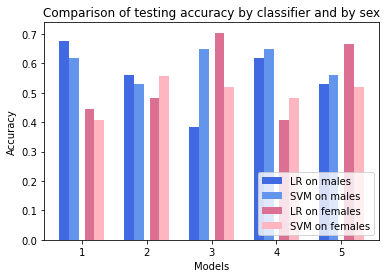

In [161]:
index = np.arange(len(scores_m_lr))
bar_width = 0.15

fig, ax = plt.subplots()
lr_m = ax.bar(index, scores_m_lr, bar_width,
                label="LR on males", color='royalblue')

svm_m = ax.bar(index+bar_width, scores_m_svm, bar_width,
                label="SVM on males", color="cornflowerblue")

lr_f = ax.bar(index+2.6*bar_width, scores_f_lr,
                 bar_width, label="LR on females", color="palevioletred")

svm_f = ax.bar(index+3.6*bar_width, scores_f_svm,
                 bar_width, label="SVM on females", color="lightpink")

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of testing accuracy by classifier and by sex')
ax.set_xticks(index + 3.6*bar_width / 2)
ax.set_xticklabels(np.arange(len(scores_m_lr))+1)
ax.legend(loc="lower right")
plt.savefig("../final_report/img/test_plot_corrmatrix.png")
plt.show()


# Repeating the experiment with connectivity matrices (correlation matrices transformed with Fisher's z-transform)

## Training

### Logistic Regression

In [162]:
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

outer_results_lr = []
outer_results_train_lr = []
best_models_lr_connectmatrix = []
for train_ix, test_ix in cv_outer.split(X_train_transformed, y_train_transformed):
    X_train_nested, X_test_nested = X_train_transformed[train_ix, :], X_train_transformed[test_ix, :]
    y_train_nested, y_test_nested = y_train_transformed[train_ix], y_train_transformed[test_ix]
    # configure the cross-validation procedure
    cv_inner = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    model_lr =LogisticRegression(solver="liblinear", penalty="l1")
    # define search space
    # p_grid = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}  # first try: best param was either 0.1 or 0.5 -> try to fine-tune around this range
    p_grid = {"C": [0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
    # define search
    clf_lr = GridSearchCV(estimator=model_lr, param_grid=p_grid, cv=cv_inner, scoring='accuracy', n_jobs=1, return_train_score=True, refit=True)
    # execute search
    result_lr = clf_lr.fit(X_train_nested, y_train_nested)
    # get the best performing model fit on the whole training set
    best_model_lr = result_lr.best_estimator_
    yhat_lr = best_model_lr.predict(X_test_nested)
    # evaluate the model
    acc_lr = accuracy_score(y_test_nested, yhat_lr)
    acc_train_lr = clf_lr.cv_results_['mean_train_score']
    # store the result
    best_models_lr_connectmatrix.append(best_model_lr)
    outer_results_lr.append(acc_lr)
    outer_results_train_lr.append(acc_train_lr)
    # report progress
    print('>Accuracy=%.3f (train: %.3f), Best score=%.3f, Best param=%s' % (acc_lr, mean(acc_train_lr), result_lr.best_score_, result_lr.best_params_))
# summarize the estimated performance of the model
print('LR: Accuracy: mean %.3f (std %.3f)' % (mean(outer_results_lr), std(outer_results_lr)))

>Accuracy=0.580 (train: 0.833), Best score=0.535, Best param={'C': 0.2}
>Accuracy=0.594 (train: 0.833), Best score=0.541, Best param={'C': 0.2}
>Accuracy=0.574 (train: 0.839), Best score=0.553, Best param={'C': 0.1}
>Accuracy=0.574 (train: 0.825), Best score=0.548, Best param={'C': 0.3}
>Accuracy=0.544 (train: 0.833), Best score=0.598, Best param={'C': 0.09}
LR: Accuracy: mean 0.573 (std 0.016)


### SVM

In [163]:
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

outer_results_svm = []
outer_results_train_svm = []
best_models_svm_connectmatrix = []
for train_ix, test_ix in cv_outer.split(X_train_transformed, y_train_transformed):
    X_train_nested, X_test_nested = X_train_transformed[train_ix, :], X_train_transformed[test_ix, :]
    y_train_nested, y_test_nested = y_train_transformed[train_ix], y_train_transformed[test_ix]
    # configure the cross-validation procedure
    cv_inner = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    model_svm = SVC(kernel="linear")
    # define search space
    # p_grid = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}  # first try: best param was 0.01 -> try to fine-tune around this range
    p_grid = {"C": [0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013]}    # define search
    clf_svm = GridSearchCV(estimator=model_svm, param_grid=p_grid, cv=cv_inner, return_train_score=True,  n_jobs=1, refit=True)
    # execute search
    result_svm = clf_svm.fit(X_train_nested, y_train_nested)
    # get the best performing model fit on the whole training set
    best_model_svm = result_svm.best_estimator_
    yhat_svm = best_model_svm.predict(X_test_nested)
    # evaluate the model
    acc_svm = accuracy_score(y_test_nested, yhat_svm)
    acc_train_svm = clf_svm.cv_results_['mean_train_score']
    # store the result
    best_models_svm_connectmatrix.append(best_model_svm)
    outer_results_svm.append(acc_svm)
    outer_results_train_svm.append(acc_train_svm)
    # report progress
    print('>Accuracy=%.3f (train: %.3f), Best score=%.3f, Best param=%s' % (acc_svm, mean(acc_train_svm), result_svm.best_score_, result_svm.best_params_))
# summarize the estimated performance of the model
print('SVM: Accuracy: mean %.3f (std %.3f)' % (mean(outer_results_svm), std(outer_results_svm)))

>Accuracy=0.522 (train: 0.930), Best score=0.554, Best param={'C': 0.007}
>Accuracy=0.580 (train: 0.929), Best score=0.570, Best param={'C': 0.008}
>Accuracy=0.544 (train: 0.937), Best score=0.558, Best param={'C': 0.011}
>Accuracy=0.574 (train: 0.934), Best score=0.536, Best param={'C': 0.008}
>Accuracy=0.544 (train: 0.941), Best score=0.572, Best param={'C': 0.013}
SVM: Accuracy: mean 0.553 (std 0.021)


## Testing

In [164]:
scores_f_lr = []
for model in best_models_lr_connectmatrix:
    pred_f = model.predict(X_females_test)
    acc_f = accuracy_score(y_females_test, pred_f)
    scores_f_lr.append(acc_f)
scores_f_lr

[0.4444444444444444,
 0.48148148148148145,
 0.5925925925925926,
 0.37037037037037035,
 0.5555555555555556]

In [165]:
scores_m_lr = []
for model in best_models_lr_connectmatrix:
    pred_m = model.predict(X_males_test)
    acc_m = accuracy_score(y_males_test, pred_m)
    scores_m_lr.append(acc_m)
scores_m_lr

[0.6764705882352942,
 0.5588235294117647,
 0.6176470588235294,
 0.6176470588235294,
 0.5588235294117647]

In [166]:
scores_f_svm = []
for model in best_models_svm_connectmatrix:
    pred_f = model.predict(X_females_test)
    acc_f = accuracy_score(y_females_test, pred_f)
    scores_f_svm.append(acc_f)
scores_f_svm

[0.4444444444444444,
 0.5555555555555556,
 0.5185185185185185,
 0.48148148148148145,
 0.5555555555555556]

In [167]:
scores_m_svm = []
for model in best_models_svm_connectmatrix:
    pred_m = model.predict(X_males_test)
    acc_m = accuracy_score(y_males_test, pred_m)
    scores_m_svm.append(acc_m)
scores_m_svm

[0.6470588235294118,
 0.5588235294117647,
 0.6470588235294118,
 0.6176470588235294,
 0.5588235294117647]

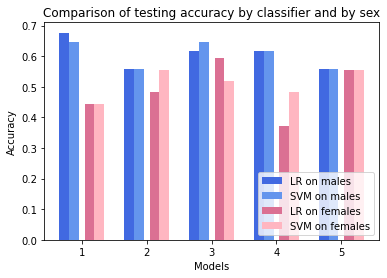

In [168]:
index = np.arange(len(scores_m_lr))
bar_width = 0.15

fig, ax = plt.subplots()
lr_m = ax.bar(index, scores_m_lr, bar_width,
                label="LR on males", color='royalblue')

svm_m = ax.bar(index+bar_width, scores_m_svm, bar_width,
                label="SVM on males", color="cornflowerblue")

lr_f = ax.bar(index+2.6*bar_width, scores_f_lr,
                 bar_width, label="LR on females", color="palevioletred")

svm_f = ax.bar(index+3.6*bar_width, scores_f_svm,
                 bar_width, label="SVM on females", color="lightpink")

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of testing accuracy by classifier and by sex')
ax.set_xticks(index + 3.6*bar_width / 2)
ax.set_xticklabels(np.arange(len(scores_m_lr))+1)
ax.legend(loc="lower right")

plt.savefig("../final_report/img/test_plot_connectmatrix.png")
plt.show()
